### Import Dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [2]:
default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['methane'] = ['methane']
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['aer'] = param_categories['aci'] + param_categories['ari']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

## Import datasets

In [3]:
# MAGICC7.1.0.beta RCMIP runs
magicc_scm = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/magicc7/rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv').set_index(['Region','Scenario','Variable'])
magicc_scm.iloc[:,3:] = magicc_scm.iloc[:,3:].apply(pd.to_numeric)
magicc_scm.columns = list(magicc_scm.columns)[:3] + [int(x) for x in list(magicc_scm.columns)[3:]]

In [4]:
## RCMIP SSP emissions:
scenarios = ['ssp'+x for x in ['119','245','585','370']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_emms = ssp_emms.loc[1750:2150] - ssp_emms.loc[1750]
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate().loc[1750:2150]

## switch in GCP co2 emissions up to start of SSPs
GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

for ssp in ssp_emms.columns.levels[0]:
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
    ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [5]:
## NROY parameter set:

pd.read_pickle('../Parameter_Sets/NROY/gas_params_mem0-mem9999.pkl')
gas_params_list = [x for x in glob.glob('../Parameter_Sets/NROY/gas_*.pkl') if not 'v1' in x]
response_param_list = [x for x in glob.glob('../Parameter_Sets/NROY/response_*.pkl') if not 'v1' in x]
level_constraint_list  = [x for x in glob.glob('../Parameter_Sets/NROY/temp*.pkl') if not 'v1' in x]
rate_constraint_list  = [x for x in glob.glob('../Parameter_Sets/NROY/rate*.pkl') if not 'v1' in x]

def return_NROY_params(gas_param_file,response_param_file,level_constraint_file,rate_constrain_file):
    level_constraint = pd.read_pickle(level_constraint_file)
    rate_constraint = pd.read_pickle(rate_constrain_file)
    full_constraint = level_constraint & rate_constraint
    NROY_mems = full_constraint.index.levels[0][full_constraint]
    gas_params = pd.read_pickle(gas_param_file).reindex(NROY_mems,axis=1,level=0)
    response_params = pd.read_pickle(response_param_file).reindex(NROY_mems,axis=1,level=0)
    return gas_params,response_params

In [6]:
param_set_start = 10000
basedir = '../Parameter_Sets/NROY/'
gas_params1, thermal_params1 = return_NROY_params(*[basedir+x+'_mem'+str(param_set_start)+'-mem'+str(param_set_start+9999)+'_v1.pkl' for x in ['gas_params','response_params','temp_constraint','rate_constraint']])

In [7]:
ssp_run1 = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=gas_params1,thermal_parameters=thermal_params1)

Integrating 4 scenarios, 2990 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'ha

100%|██████████| 400/400 [00:30<00:00, 13.13 timestep/s]


[None, None, None]

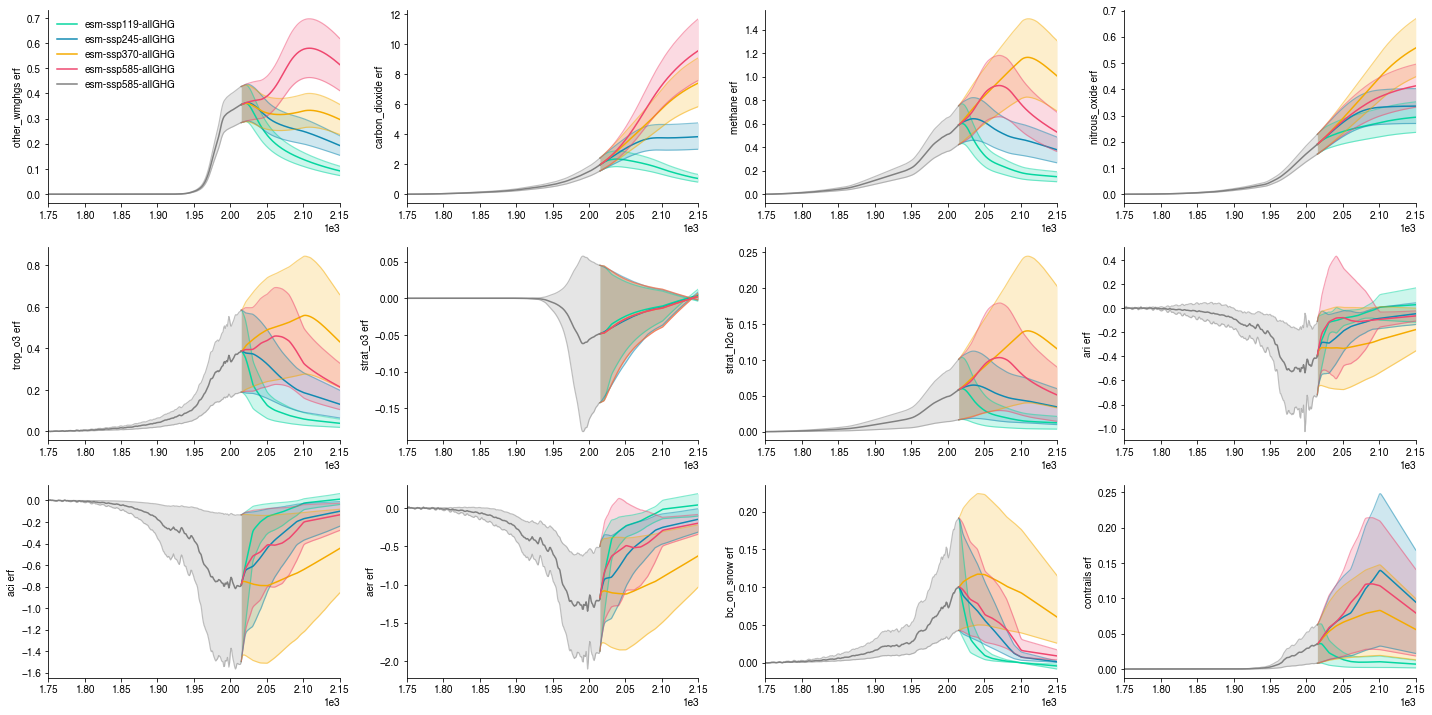

In [11]:
fig,ax=plt.subplots(3,4,figsize=(20,10))
colors= {'esm-ssp245-allGHG':'#118ab2','esm-ssp370-allGHG':'#F5AB00','esm-ssp585-allGHG':'#ef476f','esm-ssp119-allGHG':'#06d6a0','history':'grey'}
for i,forc_cat in enumerate(param_categories.keys()):
    for scenario in ssp_run1['RF'].columns.levels[0]:
        plot_data = ssp_run1['RF'].loc[:,(scenario,slice(None),param_categories[forc_cat])].groupby(level=(0,1),axis=1).sum()
        plot_data.loc[2015:].groupby(level=0,axis=1).mean().plot(ax=ax.flatten()[i],color=colors[scenario],legend=None)
        ax.flatten()[i].fill_between(plot_data.loc[2015:].index,*np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1),color=colors[scenario],alpha=0.2,lw=0)
        ax.flatten()[i].plot(plot_data.loc[2015:].index,np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1).T,color=colors[scenario],alpha=0.5,lw=1.2)
        
    plot_data.loc[:2015].groupby(level=0,axis=1).mean().plot(ax=ax.flatten()[i],color=colors['history'],legend=None)
    ax.flatten()[i].fill_between(plot_data.loc[:2015].index,*np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1),color=colors['history'],alpha=0.2,lw=0)
    ax.flatten()[i].plot(plot_data.loc[:2015].index,np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1).T,color=colors['history'],alpha=0.5,lw=1.2)
        
    ax.flatten()[i].set_ylabel(forc_cat+' erf')

[a.spines[pos].set_visible(False) for a in ax.flatten() for pos in ['right','top']]
[a.set_xlim(1750,2150) for a in ax.flatten()]
ax.flatten()[0].legend(loc='best')
plt.tight_layout()

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_ERF_grid.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

In [9]:
## Import some temperature data
baseline = ['1850','1900']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


[None, None, None]

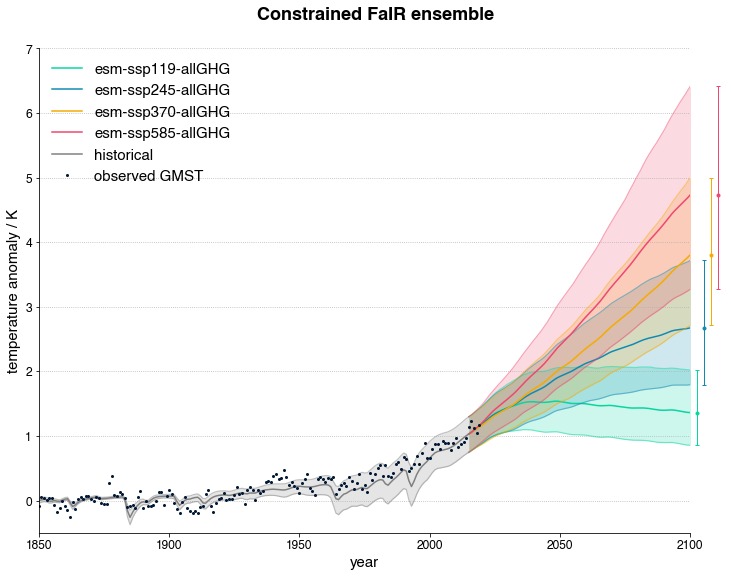

In [10]:
fig = plt.figure(figsize=(10,7.5))
gs = fig.add_gridspec(1, 20,wspace=0)
ax = fig.add_subplot(gs[0,:-1])
colors= {'esm-ssp245-allGHG':'#118ab2','esm-ssp370-allGHG':'#F5AB00','esm-ssp585-allGHG':'#ef476f','esm-ssp119-allGHG':'#06d6a0','history':'grey'}
for scenario in ssp_run1['T'].columns.levels[0]:
    plot_data = ssp_run1['T'].loc[:,(scenario)] - ssp_run1['T'].loc[1850:1900,(scenario)].mean()
    plot_data.loc[2015:].mean(axis=1).plot(ax=ax,color=colors[scenario],label=scenario)
    ax.fill_between(plot_data.loc[2015:].index,*np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1),color=colors[scenario],alpha=0.2,lw=0)
    ax.plot(plot_data.loc[2015:].index,np.quantile(plot_data.loc[2015:],[0.05,0.95],axis=1).T,color=colors[scenario],alpha=0.5,lw=1.2)
    
plot_data = ssp_run1['T'].loc[:,(scenario)] - ssp_run1['T'].loc[1850:1900,(scenario)].mean()
plot_data.loc[:2015].mean(axis=1).plot(ax=ax,color=colors['history'],label='historical')
ax.fill_between(plot_data.loc[:2015].index,*np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1),color=colors['history'],alpha=0.2,lw=0)
ax.plot(plot_data.loc[:2015].index,np.quantile(plot_data.loc[:2015],[0.05,0.95],axis=1).T,color=colors['history'],alpha=0.5,lw=1.2)
    
plt.plot(np.arange(1850,2020),GMST_datasets.loc[:'2019'].mean(axis=1).resample('y').mean().values,'.',ms=4,label='observed GMST')

ax1 = fig.add_subplot(gs[0,-1])
for i,scenario in enumerate(ssp_run1['T'].columns.levels[0]):
    plot_data = ssp_run1['T'].loc[2100,(scenario)] - ssp_run1['T'].loc[1850:1900,(scenario)].mean()
    plot_mean = plot_data.mean()
    plot_lower =  plot_mean - np.quantile(plot_data,0.05)
    plot_upper = np.quantile(plot_data,0.95) - plot_mean
    ax1.errorbar(i,plot_mean,np.array([[plot_lower],[plot_upper]]),color=colors[scenario],capsize=2,fmt='.',lw=1)

ax.yaxis.grid(ls=':')
ax.set_ylim(-0.5,7)
ax1.set_ylim(-0.5,7)
ax1.axis('off')
[ax.spines[pos].set_visible(False) for pos in ['right','top']]
ax.set_xlim(1850,2100)
ax1.set_xlim(-1,4)
ax.legend(loc='upper left',fontsize=15)
plt.tight_layout()
ax.set_ylabel('temperature anomaly / K',fontsize=15)
ax.set_xlabel('year',fontsize=15)
ax.tick_params(labelsize=12)
ax.ticklabel_format(style="plain")

fig.suptitle('Constrained FaIR ensemble',fontweight='bold',fontsize=18,y=1.05)

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_temp.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Default parameter historical run

In [11]:
## import concentrations:
CMIP6_conc_ftp = ftplib.FTP('data.iac.ethz.ch','anonymous')
CMIP6_conc_ftp.cwd('CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701')
CMIP6_ftp_list = [x for x in CMIP6_conc_ftp.nlst() if x[-3:]=='csv']
WMGHG_concs = pd.DataFrame(dict(zip(['_'.join(x.split('_')[3:-8]) for x in CMIP6_ftp_list],[pd.read_csv('ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/'+x,usecols=[0,1],index_col=0).iloc[:,0] for x in CMIP6_ftp_list])))
WMGHG_concs = WMGHG_concs[[x for x in WMGHG_concs.columns if x[-2:]!='eq']] # remove "equivalent" concentrations

WMGHG_concs['halon1202'] = 0
WMGHG_concs.loc[1765:2014,'halon1202'] = pd.read_csv('http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_MIDYEAR_CONCENTRATIONS.DAT',skiprows=38,delim_whitespace=True,index_col=0)['HALON1202'].loc[1765:2014].values

NOAA_mole_fractions_2020 = pd.read_csv('https://www.esrl.noaa.gov/gmd/aggi/NOAA_MoleFractions_2020.csv',skiprows=2,index_col=0,skipfooter=5).iloc[1:].replace('nd',np.nan).apply(pd.to_numeric)

scale_factor = (WMGHG_concs.loc[2014,'carbon_dioxide'] / NOAA_mole_fractions_2020.loc[2014:2015,'CO2']).values

CO2_concs = pd.Series(np.append(WMGHG_concs.loc[1750:,'carbon_dioxide'].values.flatten(),NOAA_mole_fractions_2020.loc[2015:,'CO2']*scale_factor),index=np.arange(1750,2020),name='CO2')

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [12]:
default_thermal = pd.DataFrame([[239,4.1],[0.33,0.41]],index=['d','q'],columns=pd.MultiIndex.from_product([['default'],[1,2]]))
default_ssp_run = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=pd.concat([default_params],axis=1,keys=['default']),thermal_parameters=default_thermal)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'nox_avi|contrails', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon

100%|██████████| 400/400 [00:00<00:00, 3719.86 timestep/s]


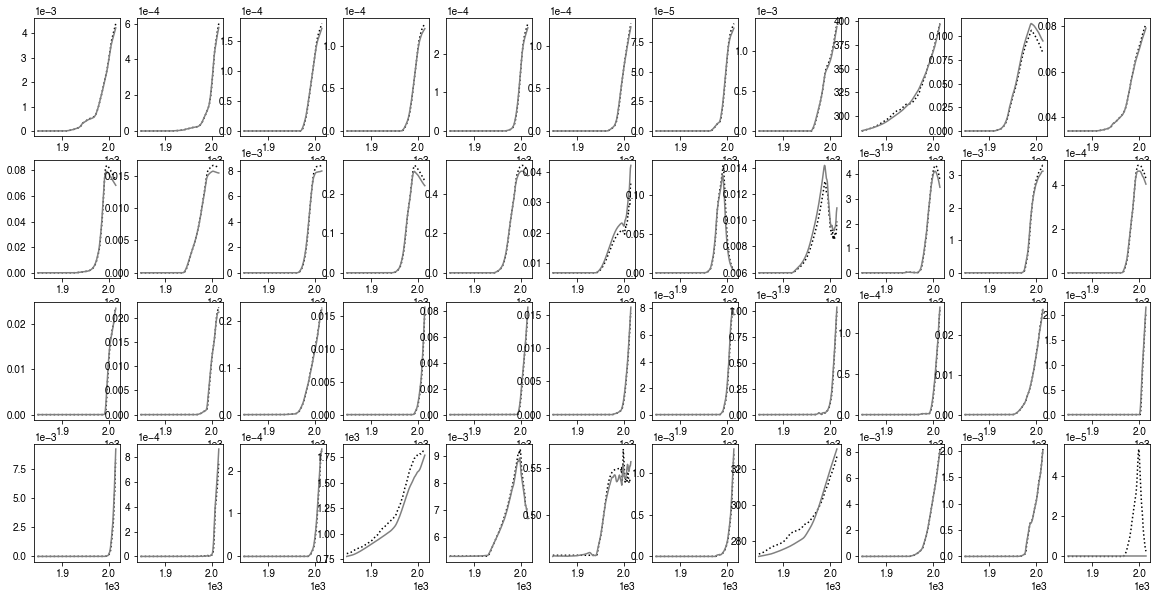

In [13]:
fig,ax = plt.subplots(4,11,figsize=(20,10))

for i,gas in enumerate(WMGHG_concs.columns):
    if gas in ['nitrous_oxide','carbon_dioxide','methane']:
        ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas],':',c='k')
    else:
        ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas]/1000,':',c='k')
    ax.flatten()[i].plot(default_ssp_run['C'].loc[1850:2014,('esm-ssp245-allGHG','default',gas)],color='grey')

## Default parameter RCP run:

In [11]:
## RCMIP SSP emissions:
scenarios = ['rcp'+x for x in ['26','45','60','85']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
rcp_emms = pd.concat([RCMIP_to_GIR_input_emms(x).dropna(axis=1,how='all').dropna() for x in scenarios],keys=scenarios,axis=1).interpolate()
rcp_emms = rcp_emms.loc[1750:2150] - rcp_emms.loc[1765]
rcp_forc = pd.concat([get_RCMIP_forc(x,drivers=['Radiative Forcing|Natural','Radiative Forcing|Anthropogenic|Albedo Change']) for x in scenarios],keys=scenarios,axis=1).interpolate().loc[1765:2150]

# ## switch in GCP co2 emissions up to start of SSPs
# GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# # set 1750 value to 0
# GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# # linearly interpolate between 0 and first land-use-change datapoint
# GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

# for ssp in ssp_emms.columns.levels[0]:
#     sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
#     ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
#     ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [13]:
rcp_run1 = run_GIR(emissions_in=rcp_emms,forcing_in=rcp_forc,gas_parameters=pd.concat([default_params.reindex([x for x in default_params.columns if x.split('|')[0] in rcp_emms.columns.levels[-1]],axis=1)],axis=1,keys=['default']),thermal_parameters=default_thermal)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c6f14', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch3ccl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc227ea', 'hfc23', 'hfc245fa', 'hfc32', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nitrous_oxide', 'sf6', 'halon1202', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', 'methyl_chloride|strat_o3', 'halon1202|strat_o3'] for

100%|██████████| 385/385 [00:00<00:00, 3379.75 timestep/s]


In [14]:
rcp_run1['C'].xs('methane',axis=1,level=-1).loc[2100]

Scenario  Gas cycle set
rcp26     default          1144.331700
rcp45     default          1531.767485
rcp60     default          1532.638906
rcp85     default          4027.867232
Name: 2100, dtype: float64

In [21]:
default_params.loc[:,default_params.loc['PI_conc']>1e-6]

,carbon_dioxide,carbon_tetrachloride,cf4,ch2cl2,chcl3,halon1211,methane,methyl_bromide,methyl_chloride,nitrous_oxide,so2
a1,2.173000e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
a2,2.240000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
a3,2.824000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
a4,2.763000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tau1,1.000000e+09,0.320000,500.000000,0.004928,0.005010,0.160000,8.100000,0.008000,0.009000,116.000000,1.000000
tau2,3.944000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
tau3,3.654000e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
tau4,4.304000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
r0,3.152000e+01,1.747128,130.983044,0.026907,0.027356,0.873564,8.100000,0.043678,0.049138,67.010000,1.000000
rC,1.223000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
